This notebook explores the relationship between rate distortion and privacy.

First, some preliminaries:

In [3]:
:set -XRebindableSyntax
:set -XNoImplicitPrelude

import Privacy.Prelude

We'll need some random variables:

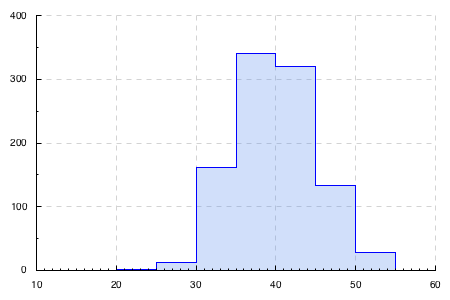

In [8]:
import System.Random
import Statistics.Distribution.Normal
import System.Random.MWC
import Statistics.Distribution
import Graphics.Rendering.Chart.Plot.Histogram.Simple

randVar :: IO Int
randVar = fromEnum <$>
    withSystemRandom (genContVar (normalDistr 40 5) `asTypeOf`
                      const (undefined :: IO Double))
                      
randomVars <- replicateM 1000 randVar

:opt svg

contHist 5 10 (map toEnum randomVars)

We can build a huffman tree from these variables:

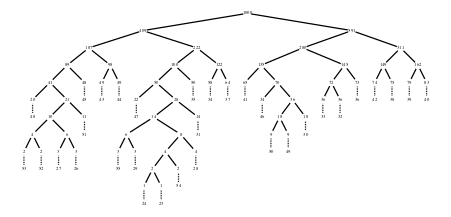

In [11]:
import Algebra.Information.Huffman
import qualified Data.List.NonEmpty as NonEmpty
import Data.Functor.Contravariant
import Data.Bifunctor

tree
    = first getSum
    $ huffmanTree defaultComparison (const (Sum 1)) 
    $ NonEmpty.fromList randomVars

tree

For $k$-anonymity, we cut off revealing the tree at a certain point. Below that point, we simply return a summary of the subtree.

We can see what value of $k$ is provided after cutting off at a certain level by taking the minimum size of subtrees at that level:

In [14]:
import Algebra.Information.Tree

rates tree

[1000,409,187,89,41,20,10,4,2,2,1]

We can plot that $k$ against the number of bits revealed

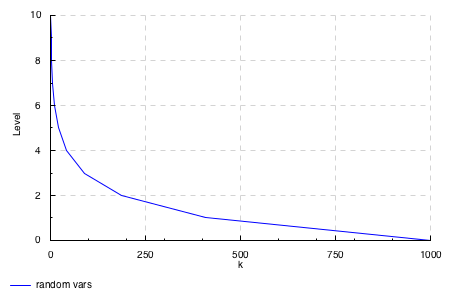

In [16]:
import Graphics.Rendering.Chart.Plot.Lines
import Graphics.Rendering.Chart.Plot
import Graphics.Rendering.Chart.Layout
import Graphics.Rendering.Chart (toRenderable)
import Control.Lens ((.~))
import Data.Default


plotRateDistortion xs
    = toRenderable
    $ layout_plots .~ [ toPlot
                      $ PlotLines
                          "random vars"
                          defaultPlotLineStyle
                          [zip xs [0..]]
                          []
                      ]
    $ layout_x_axis.laxis_title .~ "k"
    $ layout_y_axis.laxis_title .~ "Level"
    $ def

plotRateDistortion (rates tree)